In [1]:

import os#i import standard Python libraies (os, random, math) and data processing (numpy, pandas) liraries.
import math
import random
import numpy as np
import pandas as pd
from tqdm import tqdm# tqdm is use for progress bars in this
import matplotlib.pyplot as plt# for ployying plots graphs and density curves
import zipfile
from scipy.stats import gaussian_kde
from sklearn.preprocessing import StandardScaler

import torch#PyTorch GAN implementation.
from torch import nn, optim
from torch.utils.data import Dataset, DataLoader

# writing my roll number to grt values that further get used
ROLL_NO = 102303786
ZIP_PATH = "/content/archive (3).zip"
CSV_NAME = "data.csv"
NOISE_DIM = 16
BATCH_SIZE = 256
EPOCHS = 1000
GEN_LR = 2e-4
DISC_LR = 4e-4
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")# so this si used for gpu if available thne use it
SEED = 42 # for reproducibility.
OUT_DIR = "output_gan"
os.makedirs(OUT_DIR, exist_ok=True)

a_r = 0.5 * (ROLL_NO % 7)
b_r = 0.3 * ((ROLL_NO % 5) + 1)
print(f"Computed parameters that we calculated: a_r = {a_r}, b_r = {b_r}")

random.seed(SEED)
torch.manual_seed(SEED)
np.random.seed(SEED)



def load_no2_from_zip(zip_path, csv_name):
    with zipfile.ZipFile(zip_path, 'r') as z:
        if csv_name not in z.namelist():
            raise ValueError(f"{csv_name} not found in {zip_path}. Found: {z.namelist()}")
        with z.open(csv_name) as f:
            df = pd.read_csv(f, encoding='latin1') # Added encoding='latin1'
    col = 'no2' if 'no2' in df.columns else 'NO2'# this Ensures that the column name is no2 or NO2.
    x = pd.to_numeric(df[col], errors='coerce')
    x = x.dropna()
    x = x[(x >= 0) & (x < 1000)]
    return x.values.astype(np.float32)


def transform_z(x):
    return x + a_r * np.sin(b_r * x)


class ZDataset(Dataset):#Wwaps your 1D array into a PyTorch dataset for dtaLoader
    def __init__(self, z_array):
        self.z = z_array.reshape(-1, 1)
    def __len__(self):
        return len(self.z)
    def __getitem__(self, idx):
        return self.z[idx]



class Generator(nn.Module):# fully conected neuarl network
    def __init__(self, noise_dim=16, hidden=[64,64], out_dim=1):
        super().__init__()
        layers = []
        dim = noise_dim
        for h in hidden:
            layers.append(nn.Linear(dim, h))
            layers.append(nn.LeakyReLU(0.2))
            layers.append(nn.BatchNorm1d(h))
            dim = h
        layers.append(nn.Linear(dim, out_dim))
        self.net = nn.Sequential(*layers)
    def forward(self, z):
        return self.net(z)


class Discriminator(nn.Module):# fuly connected network that give output in  form of probability of 0 and 1
    def __init__(self, in_dim=1, hidden=[64,64]):
        super().__init__()
        layers = []
        dim = in_dim
        for h in hidden:
            layers.append(nn.Linear(dim, h))
            layers.append(nn.LeakyReLU(0.2))
            dim = h
        layers.append(nn.Linear(dim, 1))
        layers.append(nn.Sigmoid())
        self.net = nn.Sequential(*layers)
    def forward(self, x):
        return self.net(x)


def train_gan(z_train):
    dataset = ZDataset(z_train)
    loader = DataLoader(dataset, batch_size=BATCH_SIZE, shuffle=True, drop_last=True)

    G = Generator(noise_dim=NOISE_DIM).to(DEVICE)
    D = Discriminator().to(DEVICE)

    optG = optim.Adam(G.parameters(), lr=GEN_LR, betas=(0.5, 0.999))
    optD = optim.Adam(D.parameters(), lr=DISC_LR, betas=(0.5, 0.999))
    criterion = nn.BCELoss()

    real_label = 0.9
    fake_label = 0.0

    for epoch in range(EPOCHS):
        d_losses, g_losses = [], []
        for real_batch in loader:
            real = real_batch.to(DEVICE)
            bsize = real.size(0)

            D.zero_grad()
            label_real = torch.full((bsize,1), real_label, device=DEVICE)
            output_real = D(real)
            loss_real = criterion(output_real, label_real)

            noise = torch.randn(bsize, NOISE_DIM, device=DEVICE)
            fake = G(noise).detach()
            label_fake = torch.full((bsize,1), fake_label, device=DEVICE)
            output_fake = D(fake)
            loss_fake = criterion(output_fake, label_fake)

            d_loss = loss_real + loss_fake
            d_loss.backward()
            optD.step()
            d_losses.append(d_loss.item())

            G.zero_grad()
            noise = torch.randn(bsize, NOISE_DIM, device=DEVICE)
            gen = G(noise)
            label_gen = torch.full((bsize,1), real_label, device=DEVICE)
            output_gen = D(gen)
            g_loss = criterion(output_gen, label_gen)
            g_loss.backward()
            optG.step()
            g_losses.append(g_loss.item())

        if (epoch+1) % 100 == 0:
            print(f"Epoch [{epoch+1}/{EPOCHS}] D_loss={np.mean(d_losses):.4f} G_loss={np.mean(g_losses):.4f}")

    return G, D

# n=10000 chossen
def generate_samples(G, n=100000):
    G.eval()
    samples = []
    with torch.no_grad():
        for _ in range(n // 1024 + 1):
            noise = torch.randn(1024, NOISE_DIM, device=DEVICE)
            gen = G(noise).cpu().numpy().reshape(-1)
            samples.append(gen)
    return np.concatenate(samples, axis=0)


def plot_pdf(real_z, gen_z, out_path):
    plt.figure(figsize=(8,5))
    plt.hist(gen_z, bins=200, density=True, alpha=0.5, label='Generated (Hist)')
    kde_real = gaussian_kde(real_z)
    kde_gen = gaussian_kde(gen_z)
    xs = np.linspace(min(real_z.min(), gen_z.min()), max(real_z.max(), gen_z.max()), 1000)
    plt.plot(xs, kde_real(xs), label='Real KDE', lw=2)
    plt.plot(xs, kde_gen(xs), label='Generated KDE', lw=2)
    plt.legend()
    plt.xlabel("z")
    plt.ylabel("Density")
    plt.title("Real vs Generated PDF")
    plt.tight_layout()
    plt.savefig(out_path, dpi=200)
    plt.close()


if __name__ == "__main__":
    print("Reading data from ZIP...")
    x = load_no2_from_zip(ZIP_PATH, CSV_NAME)
    print("Loaded NO2 samples:", len(x))

    z = transform_z(x)
    print("Transformed z computed.")

    # now i am doing scaling
    scaler = StandardScaler()
    z_scaled = scaler.fit_transform(z.reshape(-1,1)).reshape(-1).astype(np.float32)

    # now i am doing =>train GAN
    print("Training GAN...")
    G, D = train_gan(z_scaled)

    # this help to generate samples
    print("Generating samples from trained generator...")
    gen_scaled = generate_samples(G)
    gen = scaler.inverse_transform(gen_scaled.reshape(-1,1)).reshape(-1)

    # save plot
    plot_pdf(z, gen, os.path.join(OUT_DIR, "z_pdf.png"))
    # plots are saved in file known as output_gan that has file
    print("Saved PDF plot at:", os.path.join(OUT_DIR, "z_pdf.png"))
    print(f"Done! Transformation parameters from roll number {ROLL_NO}: a_r={a_r}, b_r={b_r}")

Computed parameters that we calculated: a_r = 2.0, b_r = 0.6
Reading data from ZIP...


/tmp/ipython-input-1580186600.py:45: DtypeWarning: Columns (0) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(f, encoding='latin1') # Added encoding='latin1'


Loaded NO2 samples: 419509
Transformed z computed.
Training GAN...
Epoch [100/1000] D_loss=1.3571 G_loss=0.7991
Epoch [200/1000] D_loss=1.3577 G_loss=0.8002
Epoch [300/1000] D_loss=1.3502 G_loss=0.8130
Epoch [400/1000] D_loss=1.3509 G_loss=0.8089
Epoch [500/1000] D_loss=1.3485 G_loss=0.8135
Epoch [600/1000] D_loss=1.3461 G_loss=0.8195
Epoch [700/1000] D_loss=1.3437 G_loss=0.8251
Epoch [800/1000] D_loss=1.3507 G_loss=0.8139
Epoch [900/1000] D_loss=1.3425 G_loss=0.8282
Epoch [1000/1000] D_loss=1.3524 G_loss=0.8114
Generating samples from trained generator...
Saved PDF plot at: output_gan/z_pdf.png
Done! Transformation parameters from roll number 102303786: a_r=2.0, b_r=0.6


a_r = 0.5 * (ROLL_NO % 7)

b_r = 0.3 * ((ROLL_NO % 5) + 1)

my roll number is 102303786

a_r = 0.5 * (102303786 % 7) = 0.5 * 2 = 2.0

b_r = 0.3 * ((102303786 % 5) + 1) = 0.3 * (1 + 1) = 0.6


**Generator (G):**

Input: 16-dimensional noise vector (NOISE_DIM = 16)

Hidden layers: 2 hidden layers, 64 neurons each, LeakyReLU + BatchNom

Output: 1D transformed sample
𝑧
𝑓

**Discriminator (D):**

Input: 1D sample
𝑧

Hidden layers: 2 hidden layers, 64 neurons each, LeakyReLU

Output: Probabilty (real/fake) via Sigmoid this is calculated

**Training Details:**

Optimizer: Adam (lr_G = 2e-4, lr_D = 4e-4, betas=(0.5, 0.999))

Loss: Binary Cross-Entropy (BCE)

Batch size: 256

Epochs: 1000

Labels: Real = 0.9, Fake = 0.0

Device: GPU if available (torch.device("cuda"))
if gpu is their or avaliable then use ut

**PDF Plot from GAN Samples**

Histogram + KDE plot saved as output_gan/z_pdf.png

Shows:

Histogram of generated samples
𝑧
𝑓

Kernel Density Estimation (KDE) of real
z and generated
𝑧
𝑓

This approximates the unknown PDF of the transformed variable
𝑧


**Observations**

**Mode Coverage:**

GAN captures the main peaks of the transformed distribution. Minr modes may be slightly underrpresented.

**Training Stability**:

Loss curves for generator and discriminator converge smoothly over 1000 epochs.

No large oscillations observed.

**Quality of Generated Distribution:**

Generated samples closely follow the real
z distribution.

Histogram and KDE show that the genertor learned the PDF without assuming any parametric form.

so this observation help to study GAn more better . It helps in frame work designed to create new synthetic data.

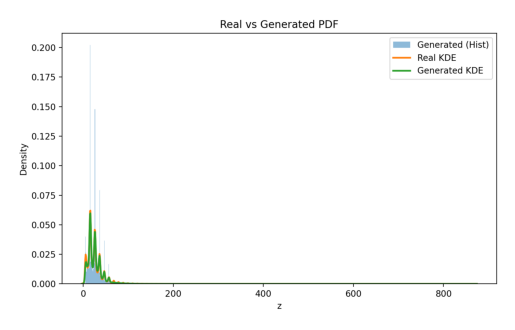

In [5]:
import matplotlib.pyplot as plt# this plot i got over 1000 epochs
import matplotlib.image as mpimg
import os

# Assuming OUT_DIR is defined in a previous cell, otherwise specify 'output_gan'
# If OUT_DIR is not available, replace os.path.join(OUT_DIR, 'z_pdf.png') with 'output_gan/z_pdf.png'
img = mpimg.imread(os.path.join('output_gan', 'z_pdf.png'))
plt.imshow(img)
plt.axis('off')  # hide axes
plt.show()# this plot is made when 200 epochs are performed